# [目标检测7日打卡营](https://aistudio.baidu.com/aistudio/course/introduce/1617?directly=1&shared=1)作业二：RCNN系列模型实战

## 实战数据集及框架

- 印刷电路板（PCB）瑕疵数据集：[数据下载链接](http://robotics.pkusz.edu.cn/resources/dataset/)，是一个公共的合成PCB数据集，由北京大学发布，其中包含1386张图像以及6种缺陷（缺失孔，鼠标咬伤，开路，短路，杂散，伪铜），用于检测，分类和配准任务。我们选取了其中适用与检测任务的693张图像，随机选择593张图像作为训练集，100张图像作为验证集。
- PaddleDetection：飞桨推出的PaddleDetection是端到端目标检测开发套件，旨在帮助开发者更快更好地完成检测模型的训练、精度速度优化到部署全流程。该框架中提供了丰富的数据增强、网络组件、损失函数等模块，集成了模型压缩和跨平台高性能部署能力。目前基于PaddleDetection已经完成落地的项目涉及工业质检、遥感图像检测、无人巡检等多个领域。

## 作业描述
基于PaddleDetection中的RCNN系列算法，完成印刷电路板（PCB）瑕疵数据集的训练与评估任务，在验证集上采用IoU=0.5，area=all的mAP作为评价指标，得分=mAP * 100，范围[0,100]，分数越高模型效果越好，及格线是60分。鼓励大家使用GPU训练，CPU训练的结果不纳入排行榜。

提示：
1. 增大训练轮数有助于网络收敛的更好，可提高mAP；
2. 增加FPN、更换Backbone等组件可增强网络的表达能力；
2. 在PaddleDetection中configs中有不同种类的RCNN系列模型，可以寻找RCNN系列性能更强的模型配置文件。（注意：由于数据集无物体分割mask信息，所以不支持Mask-RCNN）

## 解决方案：Cascade R-CNN迁移学习
**论文名称:**Cascade** **R**\-**CNN**: Delving into High Quality Object Detection**

**作者：Zhaowei Cai & Nuno Vasconcelos**

[论文链接：https://arxiv.org/abs/1712.00726](https://arxiv.org/abs/1712.00726)

[代码链接：https://github.com/zhaoweicai/**cascade**\-rcnn](https://github.com/zhaoweicai/cascade-rcnn)
### Cascade R-CNN原理
**CascadeRCNN这篇论文主要解决了在用FasterRCNN进行目标检测中，检测框不是特别准，容易出现噪声干扰的问题，即close false positive**。

首先作者分析了为什么会有这个问题，通过实验发现，因为在基于anchor的检测方法中，我们一般会设置训练的正负样本（用于训练分类以及对正样本进行坐标回归），选取正负样本的方式主要利用候选框与ground truth的IOU占比，常用的比例是50%，即IOU>0.5的作为正样本，IOU<0.3作为负样本等，但是这样就带来了一个问题，**阈值取0.5是最好的吗**？
![file](https://ai-studio-static-online.cdn.bcebos.com/ed01e087539f4e4095222d309df9d8e719cb39d031a242c4ad4f409f7954b6a0)

作者通过实验发现：

**1. 设置不同阈值，阈值越高，其网络对准确度较高的候选框的作用效果越好。**

**2. 不论阈值设置多少，训练后的网络对输入的proposal都有一定的优化作用。**

基于这两点，作者设计了**Cascade** **R**\-**CNN**网络，即通过级联的**R**\-**CNN**网络，每个级联的**R**\-**CNN**设置不同的IOU阈值，这样每个网络输出的准确度提升一点，用作下一个更高精度的网络的输入，逐步将网络输出的准确度进一步提高。

**一句话总结就是：**Cascade** **R**\-**CNN**就是使用不同的IOU阈值，训练了多个级联的检测器。**
### 学习笔记
首先就是如何在老师的指导下看懂左边的实验结果图:

![file](https://ai-studio-static-online.cdn.bcebos.com/2320196e9cd44ed092253305b65b9b831de58b0afee74dda9d79711ab8d3dd63)

<font size=5>横轴是第一阶段RPN生成的RoI和真实框的IoU，这个IoU要输入给第二阶段的BBox Head。</font>

![file](https://ai-studio-static-online.cdn.bcebos.com/1df9bf1782524f3c93a7687a1672e9507a8ab857dc4b4ed3bda0a146d6187949)

<font size=5>纵轴是经过BBox Head后得到的新bbox和真实框的IoU，显然，目标检测模型最终的bbox效果，看的是纵轴的效果。</font>

在左图中，根据第一阶段不同IoU阈值设定在第二阶段的Output IoU表现，大致可以分成三个部分：
- 标记为①的部分，IoU在0.55~0.6之间时，基于0.5的IoU阈值训练的回归器输出最佳（蓝色线）
- 标记为②的部分，IoU在0.6~0.75之间，基于0.6的IoU阈值训练的回归器输出最佳（绿色线）
- 标记为③的部分，IoU在0.75以上，基于0.7的阈值训练出的回归器输出最佳（红色线））

<font size=5 color=red>这个实验结果充分表明，第一阶段的IoU阈值并不是越大越好，因为基于0.7的IoU阈值训练出的检测器中正样本过少，因此正样本的多样性不够，容易导致训练的过拟合，因此在验证集上表现不佳。</font>
<font size=5>进而得到右图的结论，单一阈值训练出的检测器效果非常有限。</font>

<font size=5 color=green>接着，论文作者尝试了不同方式的Faster R-CNN网络结构的改进实验。最终，发现Cascade R-CNN的网络结构效果最好。</font>

![file](https://ai-studio-static-online.cdn.bcebos.com/ab4d44f23b4c42f383f7e81d493c93685bf88e39809e40f68a78edb0ae3bf418)

<font size=5 color=red>具体就是增加了一个级联的步骤，BBox Head输出的偏移量，会应用到输入的RoI上，修正得到新的RoI，进入到下一个阶段，做正负样本的选择、RoI Align的特征抽取，总共对RPN输出的ROI做了三次微调。</font>

<font size=5>Cascade R-CNN是在训练的时候就进行重新采样，训练的时候不同的stage的输入数据分布已经是不同了，可以避免出现过拟合的问题。</font>

更多参考资料：
- [一文带你读懂Cascade R-CNN，一个使你的检测更加准确的网络](https://blog.csdn.net/Chunfengyanyulove/article/details/86414810)
- [Cascade R-CNN：向高精度目标检测器迈进](https://zhuanlan.zhihu.com/p/40207812)
- [Cascade R-CNN 详细解读](https://zhuanlan.zhihu.com/p/42553957)
### 迁移学习思路
PaddleDetecion上其实提供了多种Cascade R-CNN的配置文件和预训练模型，本文参考了年初AI识虫比赛[aaaLKgo](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/110992)大佬的思路：
> 一定要使用预训练参数，object365是目前比较好的大规模图像数据集，其预训练的参数效果都比较好，即使没有预训练参数，也要自己去训练一下，再作为预训练参数拿过来；
因此选择的网络结构如下：

<font size=5>Deformable 卷积网络v2</font>

| 骨架网络 | 网络类型 | 卷积 | 每张GPU图片个数 | 学习率策略 | 推理时间(fps) | Box AP | Mask AP | 下载 | 配置文件 |
| :-- | :-- | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| SENet154-vd-FPN | Cascade Mask | c3-c5 | 1 | 1.44x | \- | 51.9 | 43.9 | [下载链接](https://paddlemodels.bj.bcebos.com/object_detection/cascade_mask_rcnn_dcnv2_se154_vd_fpn_gn_s1x.tar) | [配置文件](https://github.com/PaddlePaddle/PaddleDetection/tree/master/configs/dcn/cascade_mask_rcnn_dcnv2_se154_vd_fpn_gn_s1x.yml) |

在原配置文件基础上，除调正学习率外未作更多修改，在20000个iters内mAP就可以很快提升到98以上。配置文件与注释已在下文给出。
## 开始训练
### 数据准备
首先将印刷电路板（PCB）瑕疵数据集与PaddleDetection代码解压到`~/work/`目录中：

In [1]:
# 解压数据集
!tar -xf data/data52914/PCB_DATASET.tar -C ~/work/
# 解压PaddleDetection源码
!tar -xf data/data52899/PaddleDetection.tar -C ~/work/

### 环境安装
进行训练前需要安装PaddleDetection所需的依赖包，执行以下命令即可安装：

In [2]:
%cd ~/work/PaddleDetection
! pip install -r requirements.txt
! pip install pycocotools

/home/aistudio/work/PaddleDetection
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 1.0MB 15.4MB/s eta 0:00:01
Looking in indexes: https://mirror.baidu.com/pypi/simple/
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=278365 sha256=096b6568930812fa72fc2b9db5432ad8010d0809c97791d7c720f7f04cc81eb2
  Stored in directory: /home/aistudio/.cache/pip/wheels/fb/44/67/8baa69040569b1edbd7776ec6f82c387663e724908aaa60963
Successfully built pycocotools


## 修改配置文件
PaddleDetection中提供的配置文件是在8卡GPU环境下的配置，我们需要调整配置文件：
包括最大训练轮数(max_iters)，类别数(num_classes)，学习率(LearningRate)相关参数，数据Reader中TrainReader与EvalReader数据集路径等参数。

**注意：如在CPU下完成本作业，数据集将缩减到很小，训练集50张，测试集10张，但不推荐使用CPU训练**，GPU下请选择`train.json`和`val.json`标注文件，CPU下请选择`train_cpu.json`和`val_cpu.json`标注文件。

## GPU下配置
提示：
- 为保证模型正常训练不出Nan，学习率要根据GPU卡数，batch size变换而做线性变换，比如这里我们将GPU卡数8->1，所以base_lr除以8即可；
- 训练轮数与Epoch转换关系：根据训练集数量与总batch_size大小计算epoch数，然后将epoch数换算得到训练总轮数max_iters。milestones（学习率变化界限）也是同理。配置文件中batch_size=2，训练集数量为593，训练6个Epoch，在单卡GPU上训练，max_iters=593x6=3558。同理计算milestones为: [2372, 3261]
- RCNN系列模型的类别数num_classes需要加上背景background，所以num_classes=6+1=7

### configs/obj365/cascade_rcnn_dcnv2_se154_vd_fpn_gn_cas.yml配置文件：
```YAML
#####################################基础配置#####################################

# 检测模型的名称
architecture: CascadeRCNN
# 最大迭代次数，而一个iter会运行batch_size * device_num张图片
max_iters: 50000
# 模型保存间隔，如果训练时eval设置为True，会在保存后进行验证
snapshot_iter: 2000
# 默认使用GPU运行，设为False时使用CPU运行
use_gpu: true
# 默认打印log的间隔，默认200
log_iter: 200
# 输出指定区间的平均结果，默认200，即输出20次的平均结果
log_smooth_window: 200
# 训练权重的保存路径
save_dir: output
# 模型的预训练权重，默认是从指定url下载
pretrain_weights: https://paddlemodels.bj.bcebos.com/object_detection/cascade_mask_rcnn_dcnv2_se154_vd_fpn_gn_coco_pretrained.tar
# 用于模型验证或测试的训练好的权重
weights: output/cascade_rcnn_dcnv2_se154_vd_fpn_gn_cas/model_final
# 验证模型的评测标准，可以选择COCO或者VOC
metric: COCO
# 用于训练或验证的数据集的类别数目
# **其中包含背景类，即7=6 + 1（背景类）**
num_classes: 7

# CascadeRCNN元结构，包括了以下主要组件
CascadeRCNN:
  backbone: SENet
  fpn: FPN
  rpn_head: FPNRPNHead
  roi_extractor: FPNRoIAlign
  bbox_head: CascadeBBoxHead
  bbox_assigner: CascadeBBoxAssigner

# 主干网络
SENet:
  # SENet深度，默认152
  depth: 152
  # 主干网络返回的主要阶段特征用于FPN作进一步的特征融合
  # 默认从[2,3,4,5]返回特征
  feature_maps: [2, 3, 4, 5]
  # 是否在训练中固定某些权重，默认从第2阶段开始固定，即SENet的stage 1
  freeze_at: 2
  group_width: 4
  groups: 64
  norm_type: bn
  # 是否停止norm layer的梯度回传，默认是
  freeze_norm: True
  # SENet模型的类型,  默认使用'd'类型
  variant: d
  dcn_v2_stages: [3, 4, 5]
  std_senet: True

# FPN多特征融合
FPN:
  # FPN使用主干网络最低层特征，默认是resnet第2阶段的输出
  min_level: 2
  # FPN使用主干网络最高层特征，默认是resnet第5阶段后添加额外卷积操作变<成了FPN的第6个，总共有5个阶段
  max_level: 6
  # FPN输出特征的通道数量, 默认是256
  num_chan: 256
  # 特征图缩放比例, 默认是[0.03125, 0.0625, 0.125, 0.25]
  spatial_scale: [0.03125, 0.0625, 0.125, 0.25]
  freeze_norm: False
  norm_type: gn

# 检测第一阶段RPN
FPNRPNHead:
  # 根据特征图尺寸，在特征图的每个位置生成N个大小、长宽比各不同anchor
  # N = anchor_sizes * aspect_ratios
  # 具体实现参考[API](fluid.layers.anchor_generator)
  anchor_generator:
    anchor_sizes: [32, 64, 128, 256, 512]
    aspect_ratios: [0.5, 1.0, 2.0]
    stride: [16.0, 16.0]
    variance: [1.0, 1.0, 1.0, 1.0]
  anchor_start_size: 32
  min_level: 2
  max_level: 6
  num_chan: 256
  # 首先计算Anchor和GT BBox之间的IoU，为每个Anchor匹配上GT，
  # 然后根据阈值过滤掉IoU低的Anchor，得到最终的Anchor及其GT进行loss计算
  # 具体实现参考[API](fluid.layers.rpn_target_assign)
  rpn_target_assign:
    rpn_batch_size_per_im: 256
    rpn_fg_fraction: 0.5
    rpn_positive_overlap: 0.7
    rpn_negative_overlap: 0.3
    rpn_straddle_thresh: 0.0
  # 首先取topk个分类分数高的anchor
  # 然后通过NMS对这topk个anchor进行重叠度检测，对重叠高的两个anchor只保留得分高的
  # 训练和测试阶段主要区别在最后NMS保留的Anchor数目
  # 训练时输出2000个proposals，推理时输出1000个proposals
  # 具体实现参考[API](fluid.layers.generate_proposals)
  train_proposal:
    min_size: 0.0
    nms_thresh: 0.7
    pre_nms_top_n: 2000
    post_nms_top_n: 2000
  test_proposal:
    min_size: 0.0
    nms_thresh: 0.7
    pre_nms_top_n: 1000
    post_nms_top_n: 1000

# 对FPN每层执行RoIAlign后，然后合并输出结果，用于BBox Head计算
FPNRoIAlign:
  # 用于抽取特征特征的FPN的层数，默认为4
  canconical_level: 4
  # 用于抽取特征特征的FPN的特征图尺寸，默认为224
  canonical_size: 224
  # 用于抽取特征特征的最底层FPN，默认是2
  min_level: 2
  # 用于抽取特征特征的最高层FPN，默认是5
  max_level: 5
  # 输出bbox的特征图尺寸，默认为7
  box_resolution: 7
  # roi extractor的采样率，默认为2
  sampling_ratio: 2

# 求rpn生成的roi跟gt bbox之间的iou，然后根据阈值进行过滤，保留一定数量的roi
# 再根据gt bbox的标签，对roi进行标签赋值，即得到每个roi的类别
# 具体实现参考[API](fluid.layers.generate_proposal_labels)
# CascadeBBoxAssigner这里是级联的
CascadeBBoxAssigner:
  batch_size_per_im: 1024
  bbox_reg_weights: [10, 20, 30]
  bg_thresh_lo: [0.0, 0.0, 0.0]
  bg_thresh_hi: [0.5, 0.6, 0.7]
  fg_thresh: [0.5, 0.6, 0.7]
  fg_fraction: 0.25

# 输出检测框的Head
CascadeBBoxHead:
  head: CascadeXConvNormHead
  # 通过NMS进行bbox过滤
  # 具体实现参考[API](fluid.layers.multiclass_nms)
  nms:
    keep_top_k: 100
    nms_threshold: 0.5
    score_threshold: 0.05

CascadeXConvNormHead:
  norm_type: gn

CascadeTwoFCHead:
  mlp_dim: 1024

#####################################训练配置#####################################

# 学习率配置
LearningRate:
  # 初始学习率, 一般情况下8卡gpu，batch size为2时设置为0.02
  # 可以根据具体情况，按比例调整
  # 比如说4卡V100，bs=2时，设置为0.01
  base_lr: 0.00125
  # 学习率规划器
  # 具体实现参考[API](fluid.layers.piecewise_decay)
  schedulers:
    # 学习率衰减策略
    # 对于coco数据集，1个epoch大概需要7000个iter
    # if step < 120000:
    #    learning_rate = 0.1
    # elif 120000 <= step < 160000:
    #    learning_rate = 0.1 * 0.1
    # else:
    #    learning_rate = 0.1 * (0.1)**2
  - !PiecewiseDecay
    gamma: 0.1
    milestones: [40000, 46000]
    # 在训练开始时，调低学习率为base_lr * start_factor，然后逐步增长到base_lr，这个过程叫学习率热身，按照以下公式更新学习率
    # linear_step = end_lr - start_lr
    # lr = start_lr + linear_step * (global_step / warmup_steps)
    # 具体实现参考[API](fluid.layers.linear_lr_warmup)
  - !LinearWarmup
    start_factor: 0.01
    steps: 2000

OptimizerBuilder:
  # 默认使用SGD+Momentum进行训练
  # 具体实现参考[API](fluid.optimizer)
  optimizer:
    momentum: 0.9
    type: Momentum
  # 默认使用L2权重衰减正则化
  # 具体实现参考[API](fluid.regularizer)
  regularizer:
    factor: 0.0001
    type: L2

#####################################数据配置#####################################

# 模型训练集设置参考
# 训练、验证、测试使用的数据配置主要区别在数据路径、模型输入、数据增强参数设置
TrainReader:
  inputs_def:
    fields: ['image', 'im_info', 'im_id', 'gt_bbox', 'gt_class', 'is_crowd']
  dataset:
    !COCODataSet
    image_dir: images
    anno_path: Annotations/train.json
    dataset_dir: /home/aistudio/work/PCB_DATASET
  sample_transforms:
  - !DecodeImage
    to_rgb: True
  - !RandomFlipImage
    prob: 0.5
  - !NormalizeImage
    is_channel_first: false
    is_scale: False
    mean:
    - 102.9801
    - 115.9465
    - 122.7717
    std:
    - 1.0
    - 1.0
    - 1.0
  - !ResizeImage
    interp: 1
    target_size:
    - 608
    - 640
    - 800
    - 1408
    max_size: 1600
    use_cv2: true
  - !Permute
    channel_first: true
    to_bgr: false
  batch_transforms:
  - !PadBatch
    pad_to_stride: 32
  batch_size: 1
  worker_num: 4
  shuffle: true
  class_aware_sampling: true
  use_process: false

EvalReader:
  inputs_def:
    fields: ['image', 'im_info', 'im_id', 'im_shape']
  dataset:
    !COCODataSet
    image_dir: images
    anno_path: Annotations/val.json
    dataset_dir: /home/aistudio/work/PCB_DATASET
  sample_transforms:
  - !DecodeImage
    to_rgb: True
  - !NormalizeImage
    is_channel_first: false
    is_scale: False
    mean:
    - 102.9801
    - 115.9465
    - 122.7717
    std:
    - 1.0
    - 1.0
    - 1.0
  - !ResizeImage
    target_size: 800
    max_size: 1333
    interp: 1
  - !Permute
    channel_first: true
    to_bgr: false
  batch_transforms:
  - !PadBatch
    pad_to_stride: 32
  batch_size: 1
  drop_empty: false
  worker_num: 2

TestReader:
  batch_size: 1
  inputs_def:
    fields: ['image', 'im_info', 'im_id', 'im_shape']
  dataset:
    !ImageFolder
    anno_path: /home/aistudio/work/PCB_DATASET/Annotations/val.json
  sample_transforms:
  - !DecodeImage
    to_rgb: True
  - !NormalizeImage
    is_channel_first: false
    is_scale: False
    mean:
    - 102.9801
    - 115.9465
    - 122.7717
    std:
    - 1.0
    - 1.0
    - 1.0
  - !Permute
    channel_first: true
    to_bgr: false
  batch_transforms:
  - !PadBatch
    pad_to_stride: 32
  worker_num: 2
```

### 配置文件参考
加FPN组件的完整的配置文件，请在[https://github.com/PaddlePaddle/PaddleDetection/tree/release/0.4/configs/pcb](https://github.com/PaddlePaddle/PaddleDetection/tree/release/0.4/configs/pcb) 中查看或下载。

In [ ]:
! python -u tools/train.py -c configs/obj365/cascade_rcnn_dcnv2_se154_vd_fpn_gn_cas.yml --eval

### 评估与预测
如果在训练中加了`--eval`参数，在模型训练完就可得到mAP指标，如果要对模型单独计算mAP，可以运行：

In [ ]:
 ! python -u tools/eval.py -c configs/obj365/cascade_rcnn_dcnv2_se154_vd_fpn_gn_cas.yml \
                -o weights=output/cascade_rcnn_dcnv2_se154_vd_fpn_gn_cas/26000

2020-09-23 16:46:32,627-WARNING: paddle.fluid.layers.matrix_nms OP not found, maybe a newer version of paddle is required.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2020-09-23 16:46:36,277-INFO: places would be ommited when DataLoader is not iterable
W0923 16:46:36.534276  3046 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 9.2, Runtime API Version: 9.0
W0923 16:46:36.538686  3046 device_context.cc:260] device: 0, cuDNN Version: 7.6.
2020-09-23 16:46:46,412-INFO: Test iter 0
2020-09-23 16:47:19,194-INFO: Test finish iter 100
2020-09-23 16:47:19,194-INFO: Total number of images: 100, inference time: 2.9431218578714953 fps.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2020-09-23 16:47:19,205-INFO: Start evaluate...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11

对印刷电路板（PCB）瑕疵数据集个别图片进行可视化预测，可以运行：

In [ ]:
! python -u tools/infer.py -c configs/obj365/cascade_rcnn_dcnv2_se154_vd_fpn_gn_cas.yml \
                --infer_img=../PCB_DATASET/images/04_missing_hole_10.jpg \
                -o weights=output/cascade_rcnn_dcnv2_se154_vd_fpn_gn_cas/26000

2020-09-23 16:49:29,022-WARNING: paddle.fluid.layers.matrix_nms OP not found, maybe a newer version of paddle is required.
W0923 16:49:32.727718  3199 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 9.2, Runtime API Version: 9.0
W0923 16:49:32.732332  3199 device_context.cc:260] device: 0, cuDNN Version: 7.6.
2020-09-23 16:49:42,485-INFO: Load categories from /home/aistudio/work/PCB_DATASET/Annotations/val.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
2020-09-23 16:49:46,575-INFO: Infer iter 0
2020-09-23 16:49:46,705-INFO: Detection bbox results save in output/04_missing_hole_10.jpg


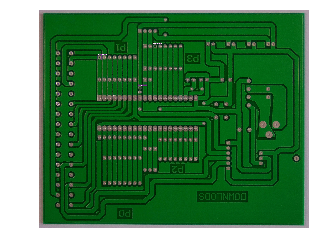

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt # plt 用于显示图片
import numpy as np
import cv2

# 读取原始图片
origin_pic = cv2.imread('output/04_missing_hole_10.jpg')
origin_pic = cv2.cvtColor(origin_pic, cv2.COLOR_BGR2RGB)
plt.imshow(origin_pic)
plt.axis('off') # 不显示坐标轴
plt.show()